## Cooling Tank Model

This notebook describes the optimization of the tank model described in `tank_model.py`. This model was developed in the fmdtools package, and requires its installation to simulate.

In [1]:
import sys
sys.path.append('../')
import numpy as np
import scipy as sp
import time
import itertools
import random
from scipy.optimize import minimize
import pandas as pd

import fmdtools.faultsim.propagate as propagate
import fmdtools.resultdisp as rd
from tank_model import Tank
from fmdtools.modeldef import SampleApproach

import matplotlib.pyplot as plt

# Simulation

### Verifying the nominal state:

In the nominal state, no change in system state should occurs.

In [2]:
mdl = Tank()
endresults, resgraph, mdlhist = propagate.nominal(mdl)

In [3]:
mdlhist.keys()

dict_keys(['flows', 'functions', 'time'])

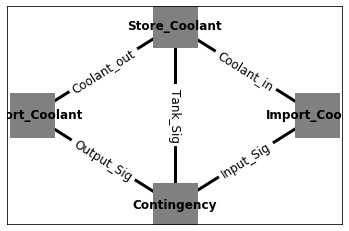

In [4]:
rd.graph.show(resgraph)

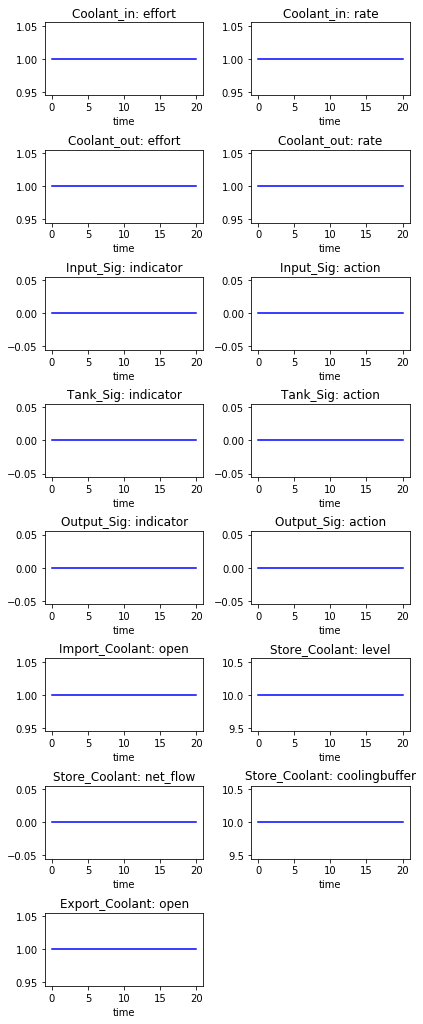

In [5]:
rd.plot.mdlhistvals(mdlhist)

### What happens under component faults?


Here we model a leak of the tank. As shown, the coolant leaks until there is no more coolant left in the tank. While this results in a warning signal, the default contingency management policy is to take no actions to alleviate the condition.

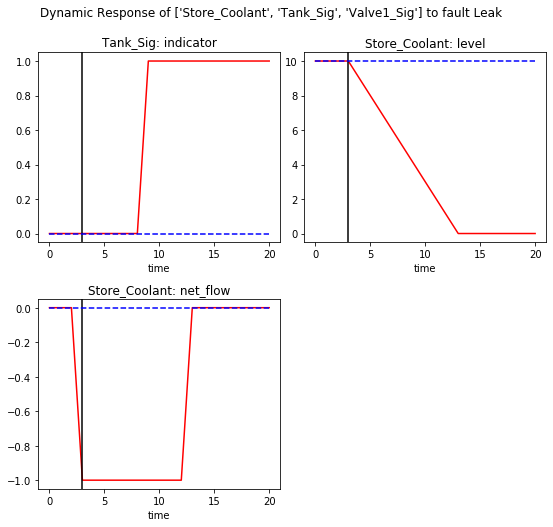

In [6]:
endresults, resgraph, mdlhist = propagate.one_fault(mdl,'Store_Coolant','Leak', time=3)

fig = rd.plot.mdlhistvals(mdlhist, fault='Leak', time=3, fxnflowvals={'Store_Coolant':['level', 'net_flow'], 'Tank_Sig':['indicator'], 'Valve1_Sig':['action']}, returnfig = True, legend=False) #,
#fig.axes[3].remove()
fig.set_figheight(8)
fig.set_figwidth(8)
fig.subplots_adjust(top = 0.9, wspace=0.1, hspace=0.3)

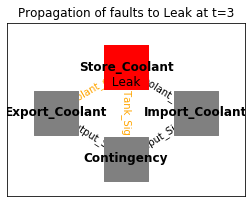

In [7]:
#add graph view to figure
graph_fig, graph_ax = rd.graph.show(resgraph,faultscen='Leak', time=3, retfig=True)
graph_ax.figure = fig
fig.axes.append(graph_ax)
fig.add_axes(graph_ax)
graph_ax.set_position([0.7,0.16,0.55,0.6])
graph_ax.margins(0.3)

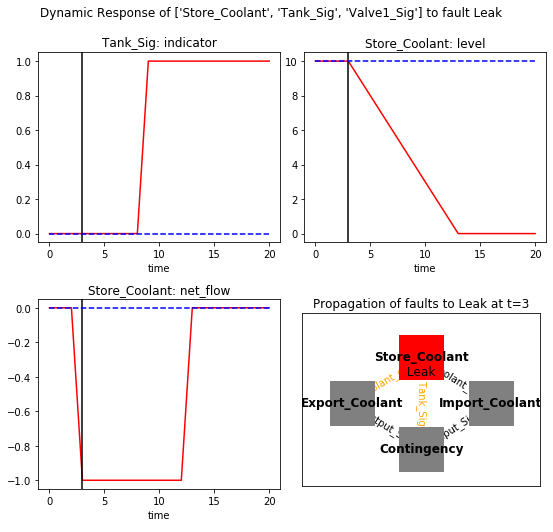

In [8]:
fig

In [9]:
fig.savefig('tank_behavior.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

### Full set of modes

The tank leak mode will not be the only mode considered, but also leak and blockage faults in the Imput/Output blocks.

In [10]:
app_joint_faults = SampleApproach(mdl)
endclasses, mdlhists = propagate.approach(mdl, app_joint_faults)
fmea_tab = rd.tabulate.simplefmea(endclasses)
fmea_tab

,rate,cost,expected cost
"Import_Coolant Leak, t=0",0.000002,2100000.0,350000.000000
"Import_Coolant Blockage, t=0",0.000002,2100000.0,350000.000000
"Store_Coolant Leak, t=0",0.000002,1000000.0,166666.666667
"Export_Coolant Leak, t=0",0.000002,1000000.0,166666.666667
"Export_Coolant Blockage, t=0",0.000002,100000.0,16666.666667


In [11]:
print(fmea_tab.to_latex(float_format="%.2g"))

\begin{tabular}{lrrr}
\toprule
{} &    rate &    cost &  expected cost \\
\midrule
Import\_Coolant Leak, t=0     & 1.7e-06 & 2.1e+06 &        3.5e+05 \\
Import\_Coolant Blockage, t=0 & 1.7e-06 & 2.1e+06 &        3.5e+05 \\
Store\_Coolant Leak, t=0      & 1.7e-06 &   1e+06 &        1.7e+05 \\
Export\_Coolant Leak, t=0     & 1.7e-06 &   1e+06 &        1.7e+05 \\
Export\_Coolant Blockage, t=0 & 1.7e-06 &   1e+05 &        1.7e+04 \\
\bottomrule
\end{tabular}



### Optimization

Here we compare the optimization of the response of this system using bilevel and alternating architectures

In [12]:
from tank_opt import *

alternating optimization structure

In [13]:
result_alt, llargs_alt, fhist_alt, thist_alt = alternating_opt()

[2.00000000e+01 1.55472633e-08]
[2.00000000e+01 2.67837142e-10]
Optimization terminated successfully.
         Current function value: 1110000.000000
         Iterations: 2
         Function evaluations: 140
['iter 0: ', 518000.0]
['iter 1: ', 355500.0]
['iter 2: ', 355500.0]
['iter 3: ', 355500.0]
['iter 4: ', 355500.0]
['iter 5: ', 355500.0]
['iter 6: ', 355500.0]
['iter 7: ', 355500.0]
['iter 8: ', 354666.6666666666]
['iter 9: ', 354666.6666666666]
['iter 10: ', 354666.6666666666]
['iter 11: ', 354666.6666666666]
['iter 12: ', 354666.6666666666]
['iter 13: ', 353833.3333333333]
['iter 14: ', 352333.33333333326]
['iter 15: ', 352333.33333333326]
['iter 16: ', 352333.33333333326]
['iter 17: ', 352333.33333333326]
['iter 18: ', 352333.33333333326]
['iter 19: ', 352333.33333333326]
0 462333.3333333698 99537666.66666663
[ 2.0000000e+01 -3.1639294e-11]
[2.00000000e+01 3.41323279e-08]
Optimization terminated successfully.
         Current function value: 462333.333333
         Iterations: 

In [14]:
result_bi, llargs_bi = bilevel_opt()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:522: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


[18.07832824  1.02799599]
[18.05704201  1.02799599]
Optimization terminated successfully.
         Current function value: 280619.103075
         Iterations: 2
         Function evaluations: 115


Text(0.5, 0, 'Computational Time (s)')

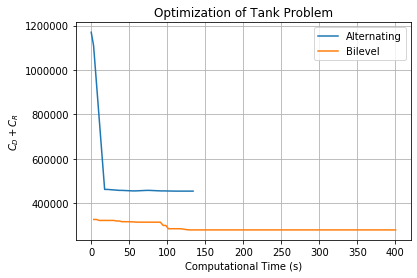

In [15]:
fig = plt.figure()
plt.plot(thist_alt, fhist_alt, label="Alternating")
plt.plot(llargs_bi['thist'],llargs_bi['fhist'], label="Bilevel")
plt.legend()
plt.title("Optimization of Tank Problem")
plt.grid()
plt.ylabel("$C_D+C_R$")
#plt.yscale("log")
plt.xlabel("Computational Time (s)")

In [16]:
fig.savefig('tank_optimization.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

In [17]:
x_to_totcost3(result_bi['x'],llargs_bi['ll_optx'][0],llargs_bi['ll_optx'][1])

281619.10307484854

In [18]:
x_to_totcost3(result_alt['x'],llargs_alt['ll_optx'][0],llargs_alt['ll_optx'][1])

454666.66666666674

In [19]:
result_bi['x']
result_alt['x']

array([2.00000000e+01, 3.41323279e-08])

In [20]:
llargs_bi['fhist'][-1]

279983.8505650433

In [21]:
tab = pd.DataFrame(columns = ["$x_t$", "$x_l$", "$f^*$", "time"])
tab.loc['Bilevel'] = list(result_bi['x']) +  [result_bi['fun'], llargs_bi['thist'][-1]]
tab.loc['Alternating'] = list(result_alt['x']) + [result_alt['fun'], thist_alt[-1]]

In [22]:
tab

,$x_t$,$x_l$,$f^*$,time
Bilevel,18.057042,1.027996e+00,280619.103075,400.315903
Alternating,20.000000,3.413233e-08,454666.666667,133.965268


In [28]:
print(tab.to_latex(float_format="%.2g" ))

\begin{tabular}{lrrrr}
\toprule
{} &  \$x\_t\$ &   \$x\_l\$ &   \$f\textasciicircum *\$ &    time \\
\midrule
Bilevel     &     18 &       1 & 2.8e+05 &   4e+02 \\
Alternating &     20 & 3.4e-08 & 4.5e+05 & 1.3e+02 \\
\bottomrule
\end{tabular}



In [24]:
llargs_bi['ll_optx'] - llargs_alt['ll_optx'] 

array([[-1., -1.,  0.,  2.,  1.,  1., -2.,  0., -1., -1.,  0.,  1., -1.,
         0.,  0., -1.,  0., -2.,  0., -2., -2., -2.,  0.,  0., -1.,  1.,
        -1.],
       [ 0.,  0.,  0.,  0.,  1.,  1., -2.,  1., -2., -1., -1.,  0.,  1.,
         0.,  0., -1.,  0., -2., -1.,  0.,  2.,  1., -1.,  0.,  1.,  1.,
         0.]])

In [25]:
opt_policy_bi = {"iv":[a-1 for a,b,c in np.ndindex((3,3,3))], "tank":[b-1 for a,b,c in np.ndindex((3,3,3))],"ov":[c-1 for a,b,c in np.ndindex((3,3,3))], "iv_act":[int(i) for i in llargs_bi['ll_optx'][0]], "ov_act":[int(i) for i in llargs_bi['ll_optx'][1]]}
opt_policy_alt = {"iv":[a-1 for a,b,c in np.ndindex((3,3,3))], "tank":[b-1 for a,b,c in np.ndindex((3,3,3))],"ov":[c-1 for a,b,c in np.ndindex((3,3,3))], "iv_act":[int(i) for i in llargs_alt['ll_optx'][0]], "ov_act":[int(i) for i in llargs_alt['ll_optx'][1]]}

In [26]:
opttab = pd.DataFrame(opt_policy_bi)
opttab

,iv,tank,ov,iv_act,ov_act
0,-1,-1,-1,-1,0
1,-1,-1,0,-1,-1
2,-1,-1,1,0,0
3,-1,0,-1,1,1
4,-1,0,0,1,0
5,-1,0,1,0,1
6,-1,1,-1,-1,-1
7,-1,1,0,0,1
8,-1,1,1,-1,-1
9,0,-1,-1,0,0


In [27]:
print(opttab.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 iv &  tank &  ov &  iv\_act &  ov\_act \\
\midrule
 -1 &    -1 &  -1 &      -1 &       0 \\
 -1 &    -1 &   0 &      -1 &      -1 \\
 -1 &    -1 &   1 &       0 &       0 \\
 -1 &     0 &  -1 &       1 &       1 \\
 -1 &     0 &   0 &       1 &       0 \\
 -1 &     0 &   1 &       0 &       1 \\
 -1 &     1 &  -1 &      -1 &      -1 \\
 -1 &     1 &   0 &       0 &       1 \\
 -1 &     1 &   1 &      -1 &      -1 \\
  0 &    -1 &  -1 &       0 &       0 \\
  0 &    -1 &   0 &       1 &      -1 \\
  0 &    -1 &   1 &       1 &       0 \\
  0 &     0 &  -1 &      -1 &       0 \\
  0 &     0 &   0 &       0 &       0 \\
  0 &     0 &   1 &       0 &       0 \\
  0 &     1 &  -1 &       0 &      -1 \\
  0 &     1 &   0 &       0 &      -1 \\
  0 &     1 &   1 &      -1 &      -1 \\
  1 &    -1 &  -1 &       0 &      -1 \\
  1 &    -1 &   0 &      -1 &       0 \\
  1 &    -1 &   1 &      -1 &       1 \\
  1 &     0 &  -1 &      -1 &       0 \\
  1 &     0 & 